In [ ]:
import pandas as pd
df = pd.read_csv('/content/sample_data/dataset.csv')
print("Initial Dataset:")
print(df.head())
def interpolate_missing_frames(df):
    df = df.sort_values(by=['trk', 'Frame']).reset_index(drop=True)

    corrected_data = []
    for trk_id, group in df.groupby('trk'):
        all_frames = set(range(group['Frame'].min(), group['Frame'].max() + 1))
        available_frames = set(group['Frame'].values)
        missing_frames = sorted(list(all_frames - available_frames))

        for missing_frame in missing_frames:
            prev_frame = group[group['Frame'] < missing_frame].iloc[-1]
            next_frame = group[group['Frame'] > missing_frame].iloc[0]

            ratio = (missing_frame - prev_frame['Frame']) / (next_frame['Frame'] - prev_frame['Frame'])
            interpolated_x = prev_frame['x'] + ratio * (next_frame['x'] - prev_frame['x'])
            interpolated_y = prev_frame['y'] + ratio * (next_frame['y'] - prev_frame['y'])
            interpolated_w = prev_frame['w'] + ratio * (next_frame['w'] - prev_frame['w'])
            interpolated_h = prev_frame['h'] + ratio * (next_frame['h'] - prev_frame['h'])

            interpolated_frame = {
                'Frame': missing_frame,
                'trk': trk_id,
                'x': int(interpolated_x),
                'y': int(interpolated_y),
                'w': int(interpolated_w),
                'h': int(interpolated_h)
            }
            corrected_data.append(interpolated_frame)

    interpolated_df = pd.DataFrame(corrected_data)
    df_corrected = pd.concat([df, interpolated_df], ignore_index=True).sort_values(by=['trk', 'Frame']).reset_index(drop=True)

    return df_corrected

df_corrected = interpolate_missing_frames(df)

print("Corrected Dataset with Interpolated Frames:")
print(df_corrected.head(10))

df_corrected = interpolate_missing_frames(df)

print("Corrected Dataset with Interpolated Frames:")
print(df_corrected.head(10))





Initial Dataset:
   Frame  trk     x     y   w   h
0      1  155  2019   417  63  30
1      1  154  2018   376  61  30
2      1  153   949  1267  56  51
3      1  152  1426  1596  71  54
4      1  151  2466  1534  38  40
Corrected Dataset with Interpolated Frames:
   Frame  trk    x    y    w   h
0      1    1  158  985  170  84
1      2    1  167  986  166  83
2      3    1  170  984  173  85
3      4    1  180  986  171  83
4      5    1  188  986  170  84
5      6    1  196  986  168  83
6      7    1  204  987  166  83
7      8    1  213  988  167  83
8      9    1  220  987  168  83
9     10    1  228  988  167  83
Corrected Dataset with Interpolated Frames:
   Frame  trk    x    y    w   h
0      1    1  158  985  170  84
1      2    1  167  986  166  83
2      3    1  170  984  173  85
3      4    1  180  986  171  83
4      5    1  188  986  170  84
5      6    1  196  986  168  83
6      7    1  204  987  166  83
7      8    1  213  988  167  83
8      9    1  220  987  168  8

In [ ]:
import numpy as np
import pandas as pd

df_corrected['center_x'] = df_corrected['x'] + df_corrected['w'] / 2
df_corrected['center_y'] = df_corrected['y'] + df_corrected['h'] / 2

size_threshold = 10000

df_corrected['initial_cls'] = np.where(df_corrected['w'] * df_corrected['h'] < size_threshold, '2-wheeler', 'car')

df_corrected['overall_cls'] = df_corrected.groupby('trk')['initial_cls'].transform(lambda x: x.mode()[0])

df_corrected['Vx_Instant_Not_Smoothed(kmph)'] = df_corrected.groupby('trk')['center_x'].diff() * 3.6
df_corrected['Vy_Instant_Not_Smoothed(kmph)'] = df_corrected.groupby('trk')['center_y'].diff() * 3.6

def get_direction(dx, dy):
    angle = np.arctan2(dy, dx) * 180 / np.pi  # Get angle in degrees
    if -22.5 <= angle < 22.5:
        return 'E'
    elif 22.5 <= angle < 67.5:
        return 'NE'
    elif 67.5 <= angle < 112.5:
        return 'N'
    elif 112.5 <= angle < 157.5:
        return 'NW'
    elif -67.5 <= angle < -22.5:
        return 'SE'
    elif -112.5 <= angle < -67.5:
        return 'S'
    elif -157.5 <= angle < -112.5:
        return 'SW'
    else:
        return 'W'

df_corrected['Smoothed_dir'] = df_corrected.apply(lambda row: get_direction(
    row['Vx_Instant_Not_Smoothed(kmph)'], row['Vy_Instant_Not_Smoothed(kmph)']), axis=1)

df_corrected['Vxy_smoothed'] = np.sqrt(df_corrected['Vx_Instant_Not_Smoothed(kmph)']**2 + df_corrected['Vy_Instant_Not_Smoothed(kmph)']**2)
top_5000_frames = df['Frame'].value_counts().head(700).index.tolist()

df_corrected = df_corrected[df_corrected['Frame'].isin(top_5000_frames)]

print(df_corrected[['Frame', 'trk', 'overall_cls', 'Smoothed_dir',
                    'Vx_Instant_Not_Smoothed(kmph)', 'Vy_Instant_Not_Smoothed(kmph)', 'Vxy_smoothed']].head(10))


   Frame  trk overall_cls Smoothed_dir  Vx_Instant_Not_Smoothed(kmph)  \
0      1    1         car            W                            NaN   
1      2    1         car            E                           25.2   
2      3    1         car            E                           23.4   
3      4    1         car            E                           32.4   
4      5    1         car            E                           27.0   
5      6    1         car            E                           25.2   
6      7    1         car            E                           25.2   
7      8    1         car            E                           34.2   
8      9    1         car            E                           27.0   
9     10    1         car            E                           27.0   

   Vy_Instant_Not_Smoothed(kmph)  Vxy_smoothed  
0                            NaN           NaN  
1                            1.8     25.264204  
2                           -3.6     23.675304  


In [ ]:
df_corrected.loc[:, 'distance'] = np.sqrt(df_corrected['x']**2 + df_corrected['y']**2)

df_corrected.loc[:, 'velocity'] = df_corrected.groupby('trk')['distance'].diff()

df_corrected.loc[:, 'acceleration'] = df_corrected.groupby('trk')['velocity'].diff()

df_corrected.loc[:, 'speed'] = (df_corrected['Vx_Instant_Not_Smoothed(kmph)']**2 + df_corrected['Vy_Instant_Not_Smoothed(kmph)']**2)**0.5

df_corrected.loc[:, 'avg_velocity_50'] = df_corrected.groupby('trk')['velocity'].rolling(window=50).mean().reset_index(level=0, drop=True)
df_corrected.loc[:, 'avg_velocity_100'] = df_corrected.groupby('trk')['velocity'].rolling(window=100).mean().reset_index(level=0, drop=True)

# Stop Patterns
# Calculate the number of stops in the past 5000 frames (velocity == 0 indicates a stop)
#df_corrected.loc[:, 'stops_5000'] = df_corrected.groupby('trk')['velocity'].rolling(window=5000).apply(lambda x: (x == 0).sum()).reset_index(level=0, drop=True)
# ====== NEW: Temporal Features ======
# Consecutive stop frames
#df_corrected['consecutive_stop_frames'] = df_corrected.groupby('trk')['velocity'].transform(
#    lambda x: x.rolling(window=5, min_periods=1).apply(lambda y: (y.abs() < 0.1).sum())
#)

# Jerk (rate of acceleration change)
df_corrected['jerk'] = df_corrected.groupby('trk')['acceleration'].diff()

# Smoothed velocity
#df_corrected['smoothed_velocity'] = df_corrected.groupby('trk')['velocity'].transform(
#    lambda x: x.ewm(alpha=0.3).mean()
#)
# Display the first few rows of the dataframe with the new features
df_corrected.head()


,Frame,trk,x,y,w,h,center_x,center_y,initial_cls,overall_cls,...,Vy_Instant_Not_Smoothed(kmph),Smoothed_dir,Vxy_smoothed,distance,velocity,acceleration,speed,avg_velocity_50,avg_velocity_100,jerk
0,1,1,158,985,170,84,243.0,1027.0,car,car,...,NaN,W,NaN,997.591600,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,167,986,166,83,250.0,1027.5,car,car,...,1.8,E,25.264204,1000.042499,2.450899,NaN,25.264204,NaN,NaN,NaN
2,3,1,170,984,173,85,256.5,1026.5,car,car,...,-3.6,E,23.675304,998.576988,-1.465512,-3.916411,23.675304,NaN,NaN,NaN
3,4,1,180,986,171,83,265.5,1027.5,car,car,...,3.6,E,32.599386,1002.295366,3.718378,5.183890,32.599386,NaN,NaN,9.100301
4,5,1,188,986,170,84,273.0,1028.0,car,car,...,1.8,E,27.059933,1003.762920,1.467555,-2.250824,27.059933,NaN,NaN,-7.434713


In [ ]:
df_corrected.head(100)
total_unique = df_corrected['Frame'].nunique()
print(total_unique)

700


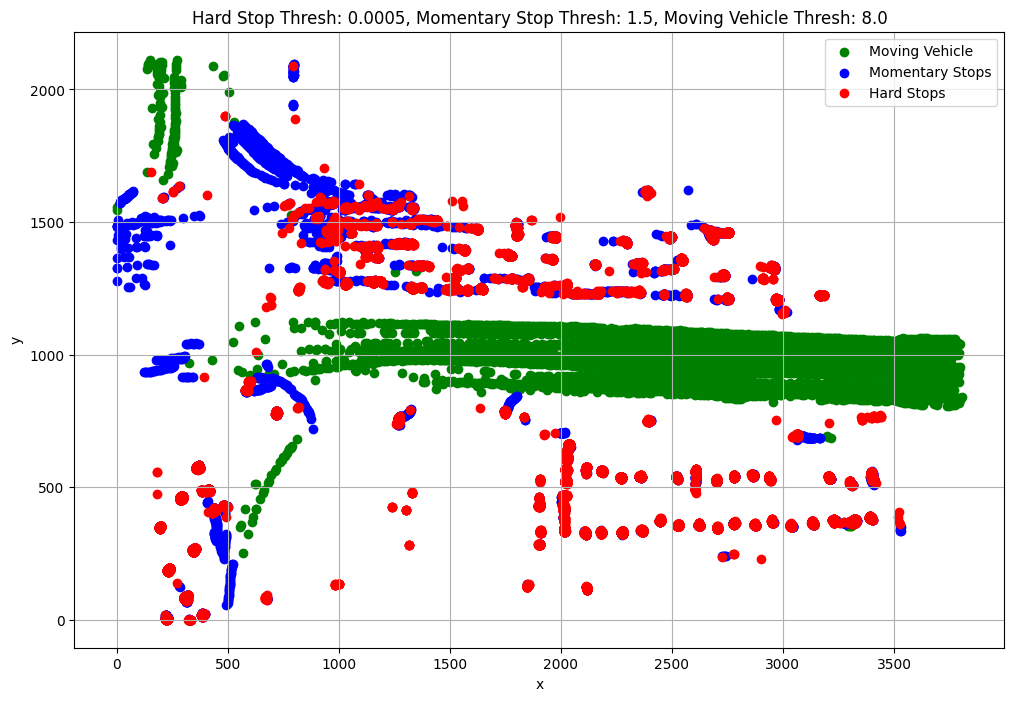

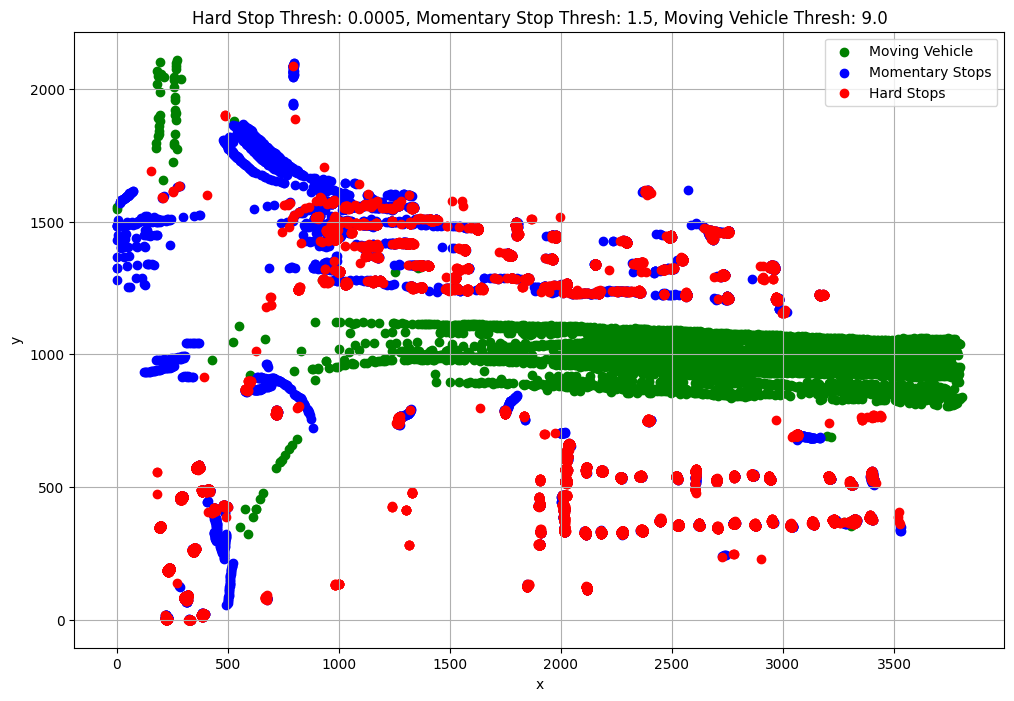

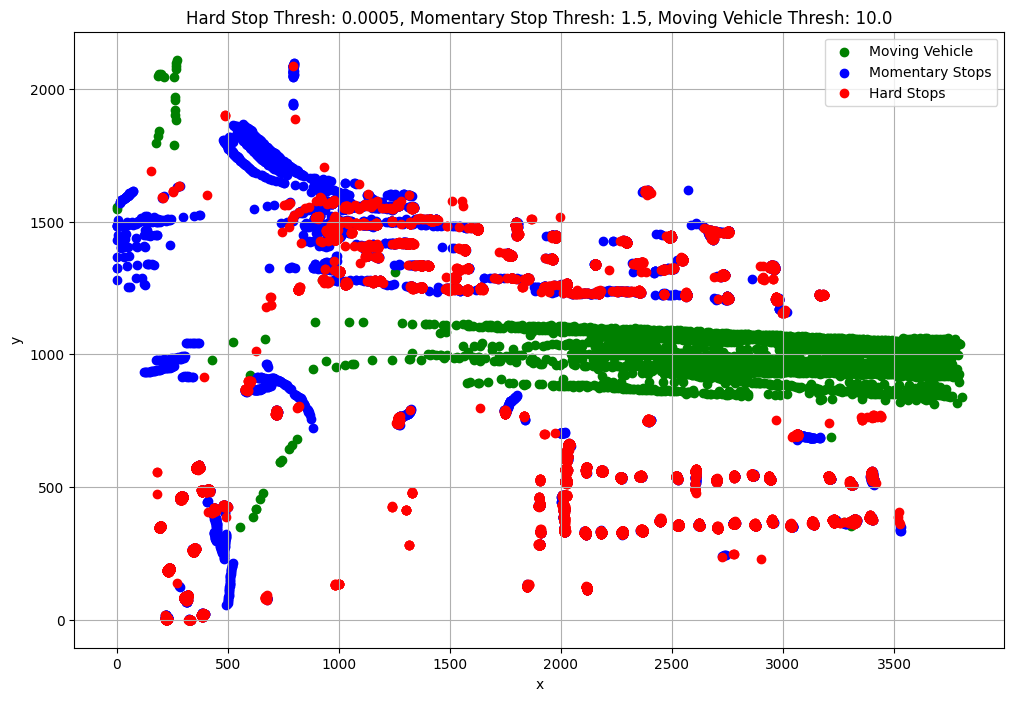

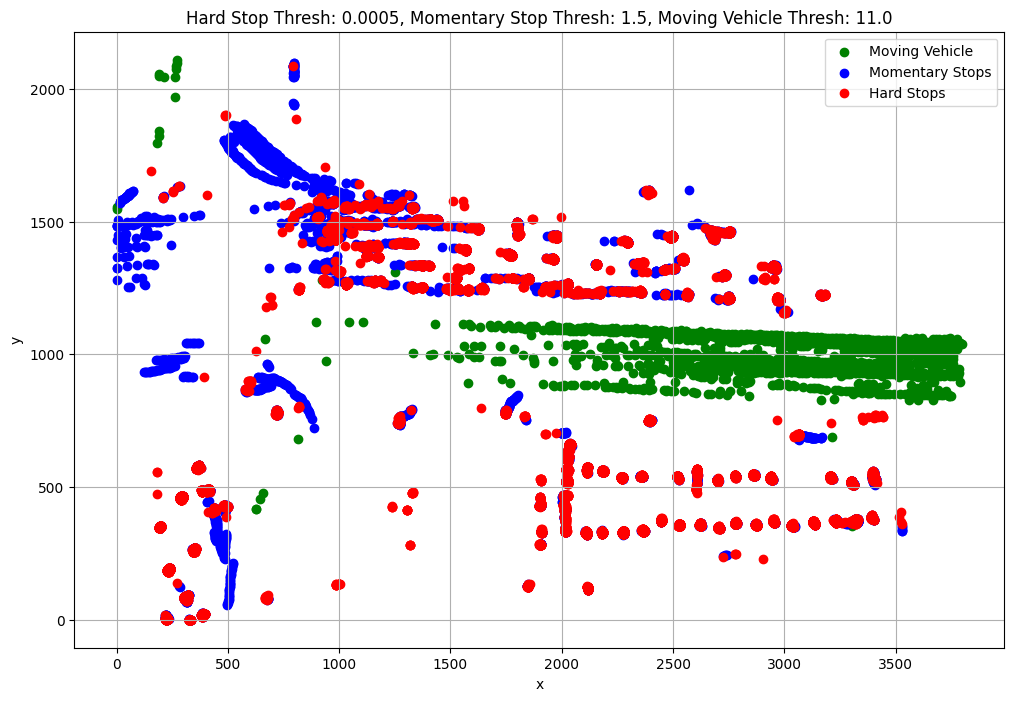

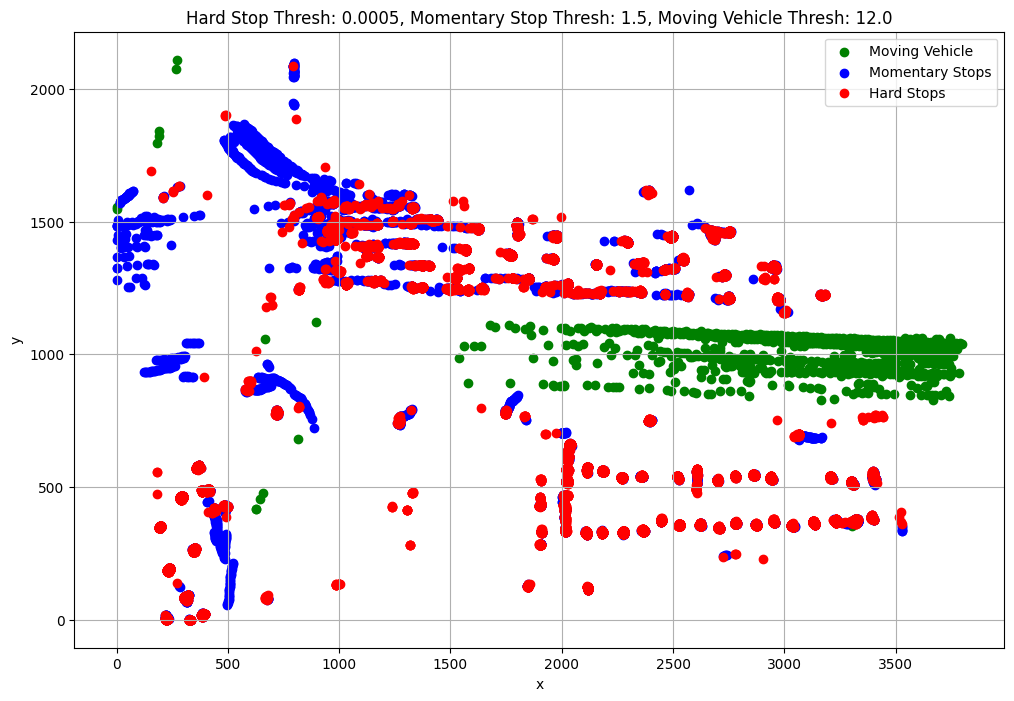

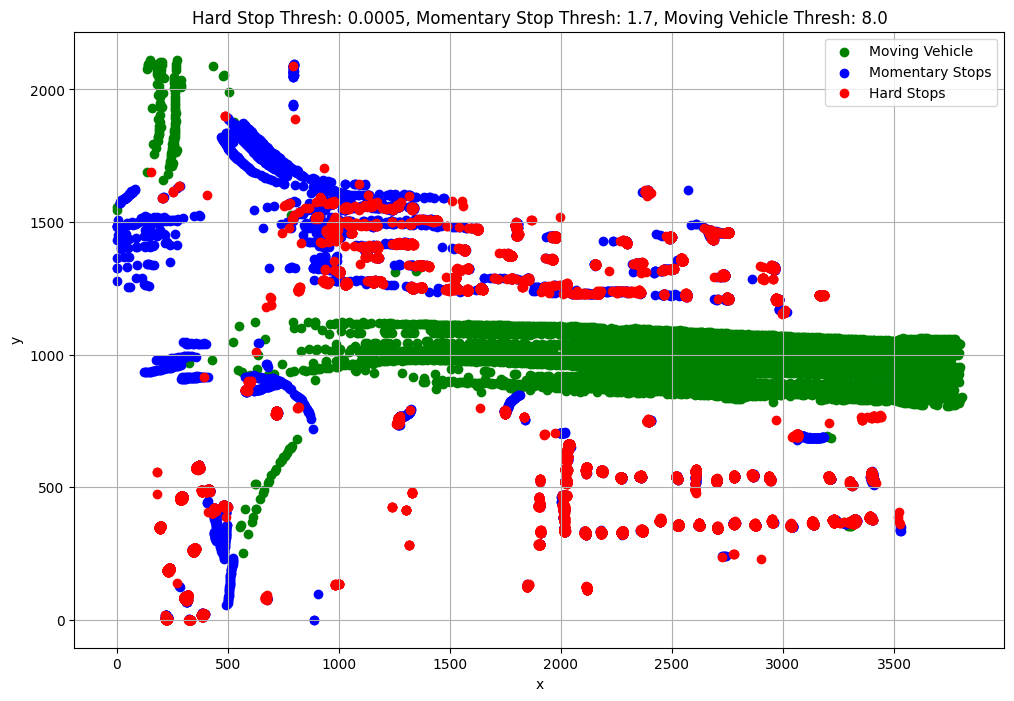

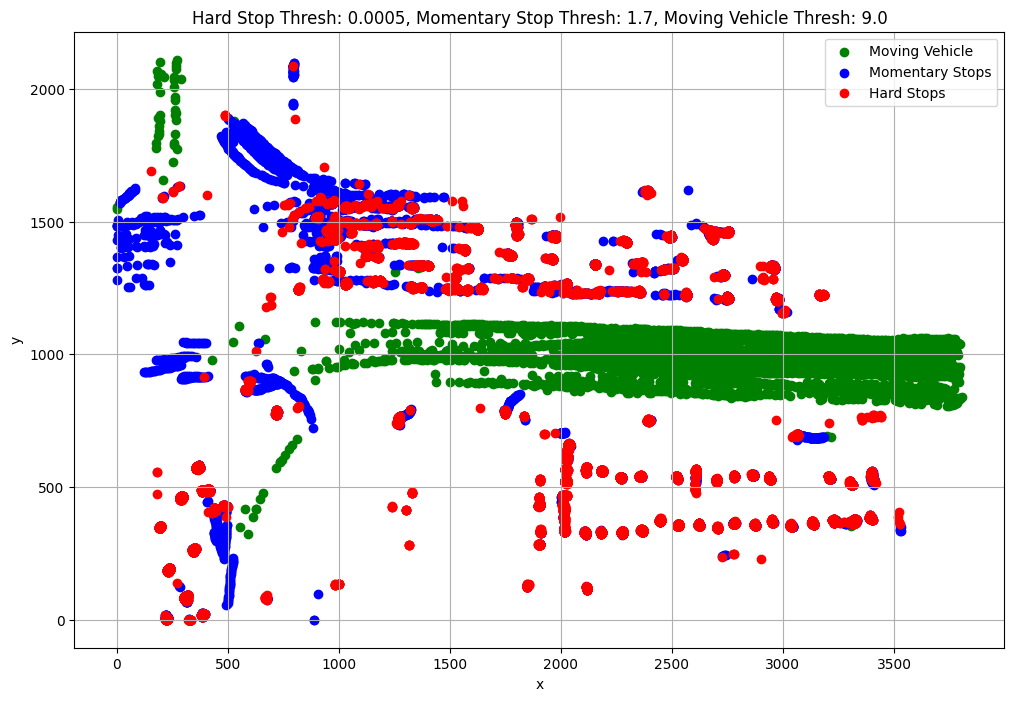

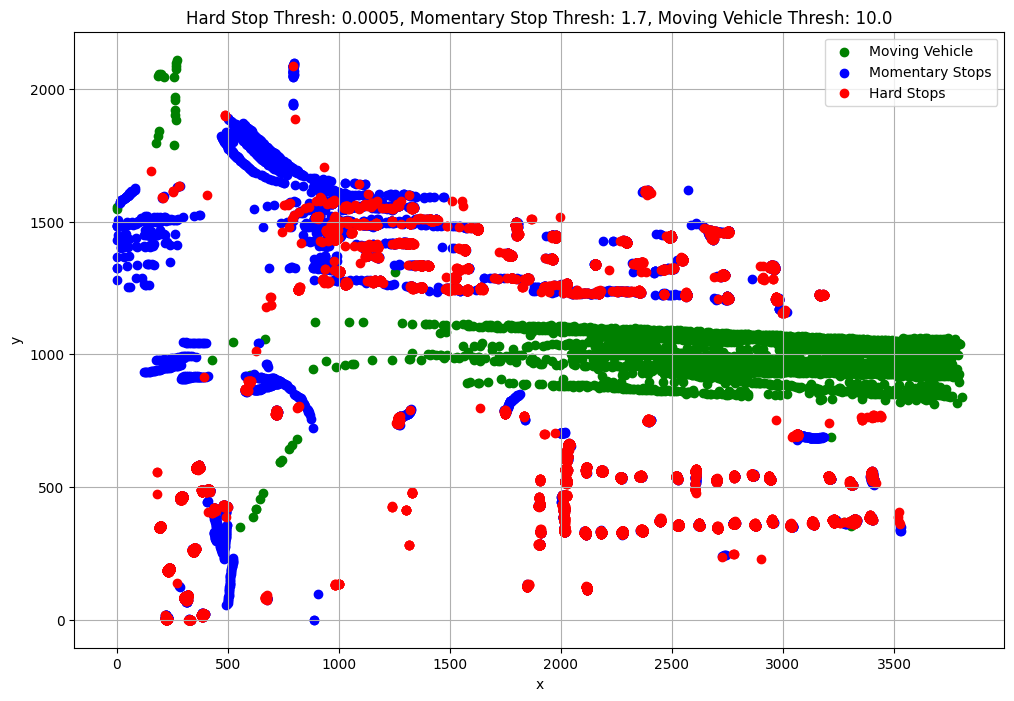

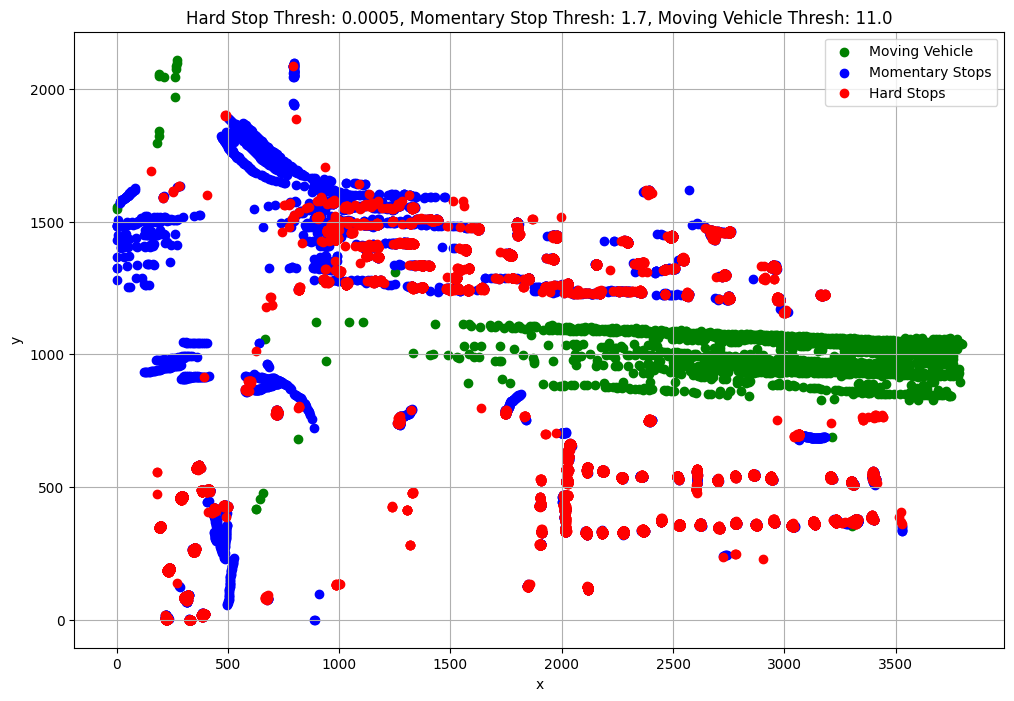

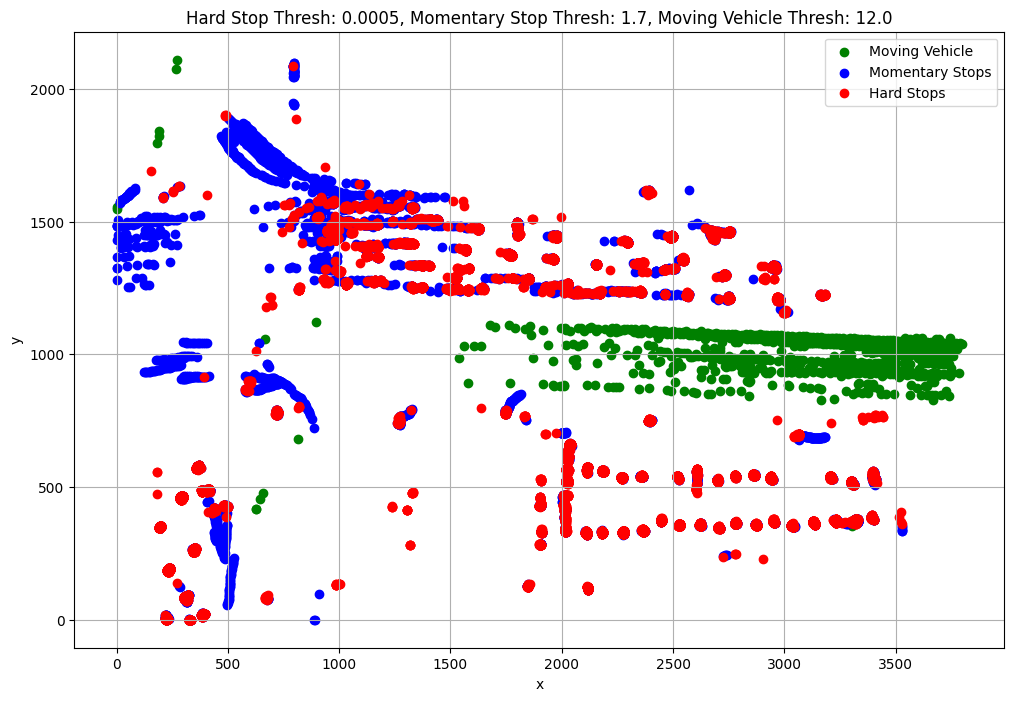

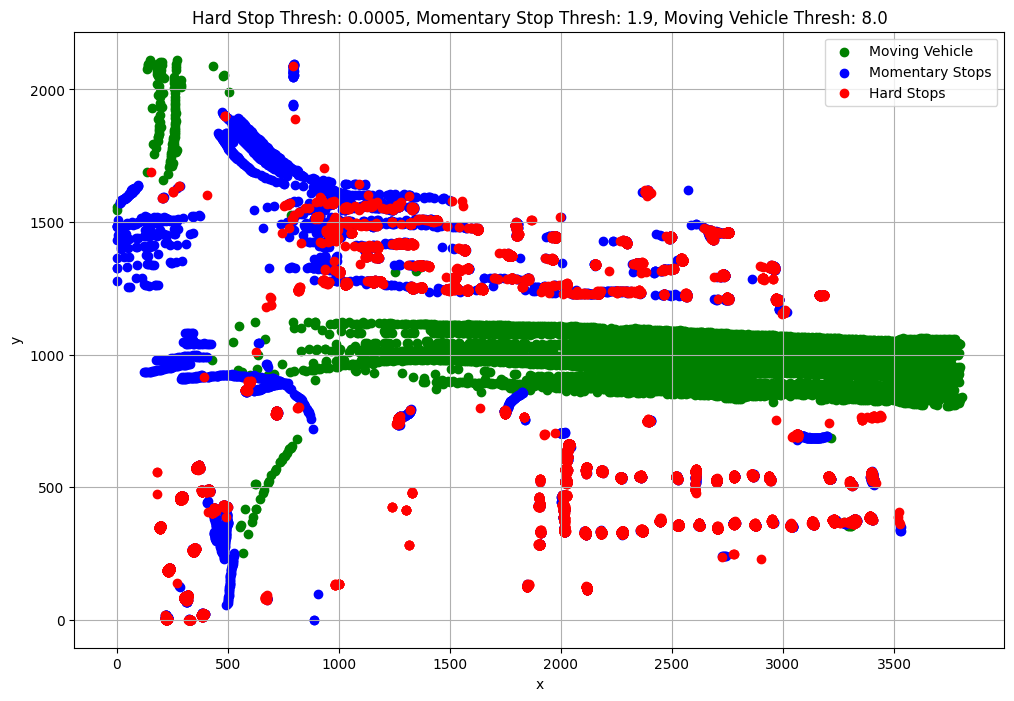

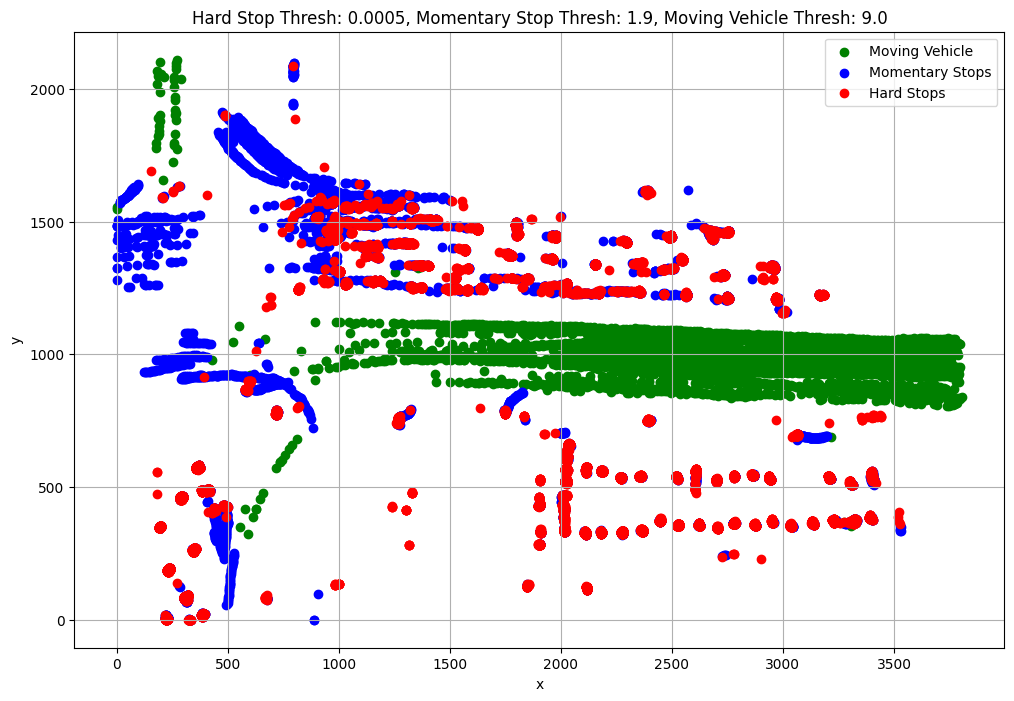

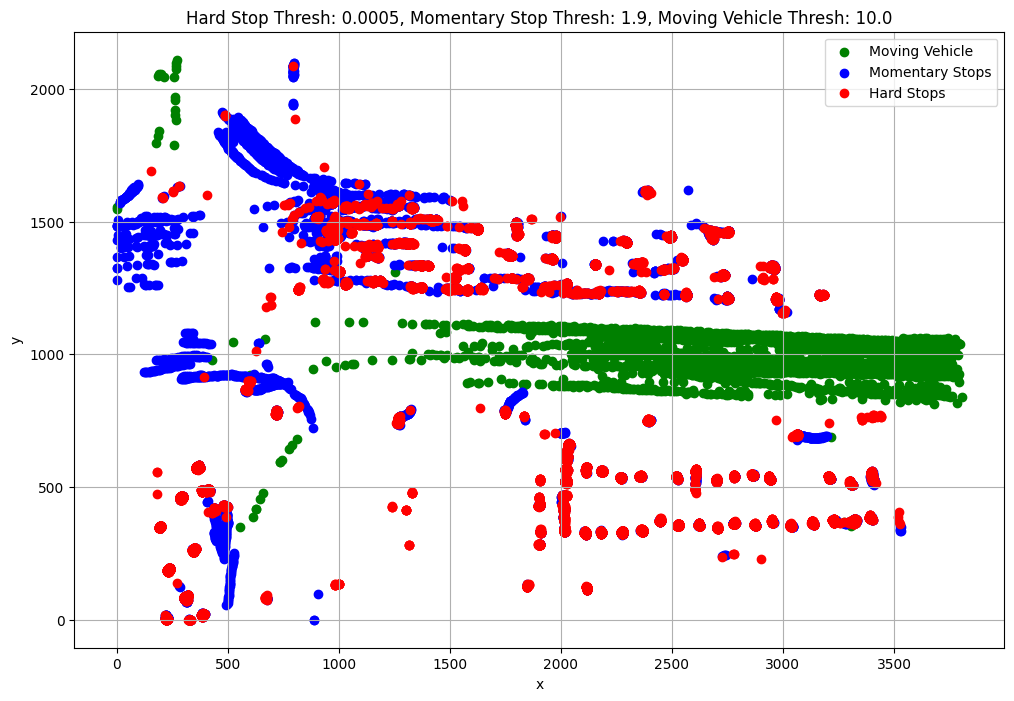

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

hard_stop_thresholds = [0.0005, 0.0007, 0.0009, 0.001, 0.0011, 0.0013, 0.0015]
momentary_stop_thresholds = [1.5, 1.7, 1.9, 2.0, 2.1, 2.3, 2.5]
moving_vehicle_thresholds = [8.0, 9.0, 10.0, 11.0, 12.0]  # Adjusted this for variability

for hard_stop_threshold in hard_stop_thresholds:
    for momentary_stop_threshold in momentary_stop_thresholds:
        for moving_vehicle_threshold in moving_vehicle_thresholds:
            df_corrected['hard_stop'] = (df_corrected['speed'].diff().abs() > hard_stop_threshold) & (df_corrected['speed'] == 0)

            df_corrected['moving_vehicle'] = (df_corrected['velocity'] > moving_vehicle_threshold) & (df_corrected['acceleration'] != 0)

            df_corrected['momentary_stop'] = (
                (df_corrected['avg_velocity_50'].abs() < momentary_stop_threshold) &
                (df_corrected['velocity'] > 0) &
                ~df_corrected['hard_stop']
            )

            x = df_corrected['x']
            y = df_corrected['y']
            hard_stop = df_corrected['hard_stop']
            momentary_stop = df_corrected['momentary_stop']
            moving_vehicle = df_corrected['moving_vehicle']

            plt.figure(figsize=(12, 8))

            plt.scatter(x[moving_vehicle], y[moving_vehicle], c='green', label='Moving Vehicle')

            plt.scatter(x[momentary_stop], y[momentary_stop], c='blue', label='Momentary Stops')

            plt.scatter(x[hard_stop], y[hard_stop], c='red', label='Hard Stops')

            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Hard Stop Thresh: {hard_stop_threshold}, Momentary Stop Thresh: {momentary_stop_threshold}, Moving Vehicle Thresh: {moving_vehicle_threshold}')  # Adding title

            plt.legend()  # Adding legend to distinguish between different categories
            plt.grid(True)  # Adding grid lines to the plot
            plt.show()  # Displaying the plot





Accuracy Score: 0.8457564229016955
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     16319
           1       0.80      0.83      0.82      2619
           2       0.50      0.37      0.43      2353

    accuracy                           0.85     21291
   macro avg       0.73      0.71      0.71     21291
weighted avg       0.84      0.85      0.84     21291

Confusion Matrix:
 [[14947   506   866]
 [  419  2181    19]
 [ 1429    45   879]]


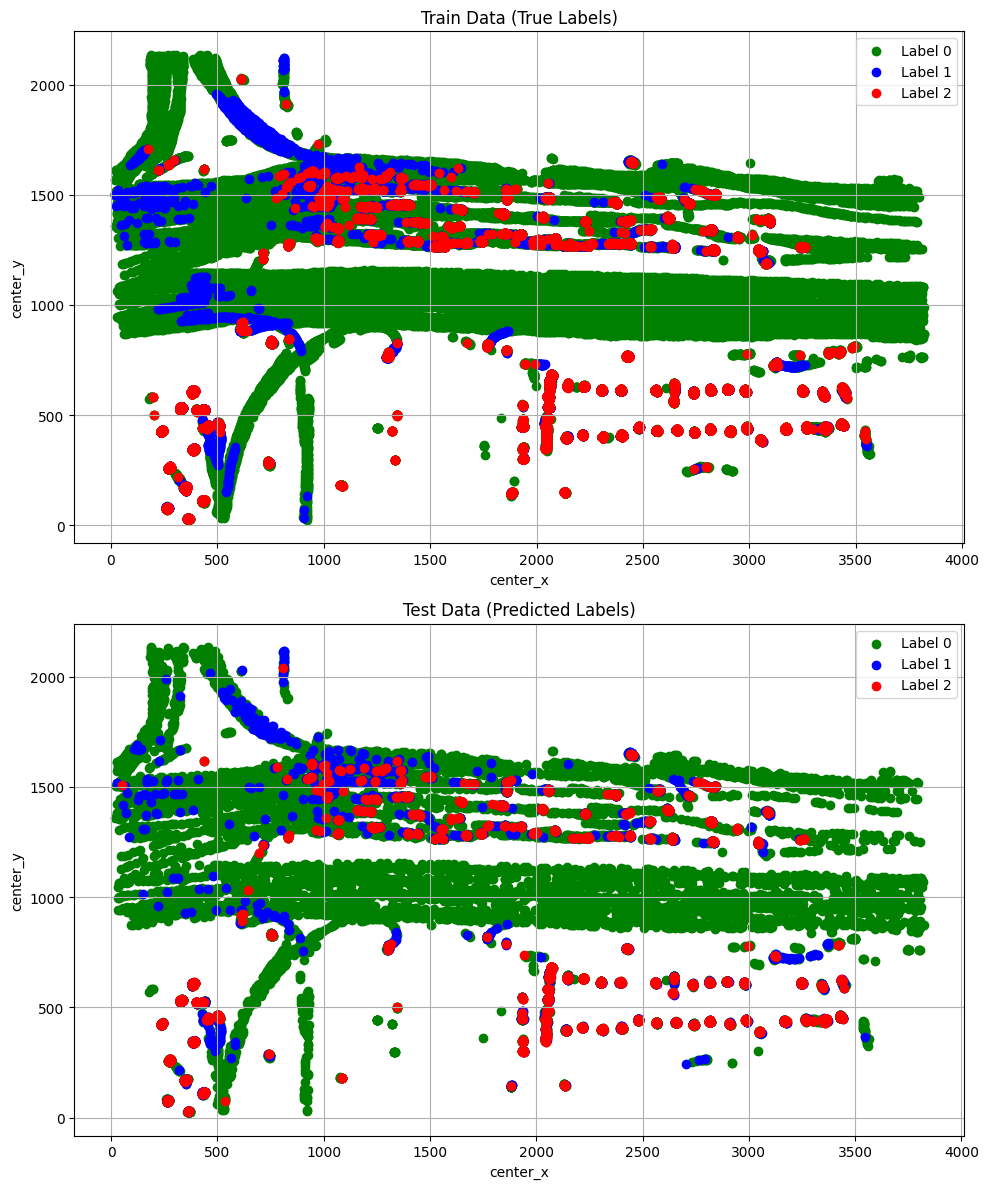

In [ ]:
# Import necessary libraries
#Midsem-Model
#Kamnu model asli niche che, aenu analysis jode aa kryu
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

hard_stop_threshold = 0.001
momentary_stop_threshold = 2.0
moving_vehicle_threshold = 10.0

df_corrected['hard_stop'] = (df_corrected['speed'].diff().abs() > hard_stop_threshold) & (df_corrected['speed'] == 0)

df_corrected['moving_vehicle'] = (df_corrected['velocity'] > moving_vehicle_threshold) & (df_corrected['acceleration'] != 0)

df_corrected['momentary_stop'] = (
    (df_corrected['avg_velocity_50'].abs() < momentary_stop_threshold) &
    (df_corrected['velocity'] > 0) &
    ~df_corrected['hard_stop']
)

df_corrected['stop_type'] = np.select(
    [
        df_corrected['hard_stop'],      # Condition for Hard Stop
        df_corrected['momentary_stop'], # Condition for Momentary Stop
        df_corrected['moving_vehicle']  # Condition for Moving Vehicle
    ],
    [2, 1, 0],
    default=0
)

X = df_corrected[['distance', 'velocity', 'acceleration']]
y = df_corrected['stop_type']

metadata = df_corrected[['center_x', 'center_y']]

X_train, X_test, y_train, y_test, train_meta, test_meta = train_test_split(
    X, y, metadata, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train_imputed, y_train)

y_pred = model.predict(X_test_imputed)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

X_train_with_coords = X_train.copy()
X_test_with_coords = X_test.copy()

X_train_with_coords['center_x'] = df_corrected.loc[X_train.index, 'center_x']
X_train_with_coords['center_y'] = df_corrected.loc[X_train.index, 'center_y']
X_train_with_coords['stop_type'] = y_train

X_test_with_coords['center_x'] = df_corrected.loc[X_test.index, 'center_x']
X_test_with_coords['center_y'] = df_corrected.loc[X_test.index, 'center_y']
X_test_with_coords['stop_type'] = y_pred

label_colors = {0: 'green', 1: 'blue', 2: 'red'}

plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
for label, color in label_colors.items():
    plt.scatter(
        X_train_with_coords[X_train_with_coords['stop_type'] == label]['center_x'],
        X_train_with_coords[X_train_with_coords['stop_type'] == label]['center_y'],
        color=color,
        label=f'Label {label}'
    )
plt.title('Train Data (True Labels)')
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.legend()
plt.grid(True)  # Add grid lines

plt.subplot(2, 1, 2)  # Subplot for test data
for label, color in label_colors.items():
    plt.scatter(
        X_test_with_coords[X_test_with_coords['stop_type'] == label]['center_x'],
        X_test_with_coords[X_test_with_coords['stop_type'] == label]['center_y'],
        color=color,
        label=f'Label {label}'
    )
plt.title('Test Data (Predicted Labels)')
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.legend()
plt.grid(True)  # Add grid lines

plt.tight_layout()
plt.show()


=== OPTIMIZED RANDOM FOREST ===
Accuracy: 0.8714
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     16319
           1       0.68      0.98      0.80      2619
           2       0.61      0.95      0.74      2353

    accuracy                           0.87     21291
   macro avg       0.76      0.92      0.82     21291
weighted avg       0.91      0.87      0.88     21291

Confusion Matrix:
 [[13748  1144  1427]
 [   47  2569     3]
 [   60    58  2235]]

=== TUNED XGBOOST ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:35:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8783
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     16319
           1       0.70      0.97      0.81      2619
           2       0.62      0.95      0.75      2353

    accuracy                           0.88     21291
   macro avg       0.77      0.92      0.83     21291
weighted avg       0.91      0.88      0.89     21291

Confusion Matrix:
 [[13931  1029  1359]
 [   77  2528    14]
 [   55    58  2240]]


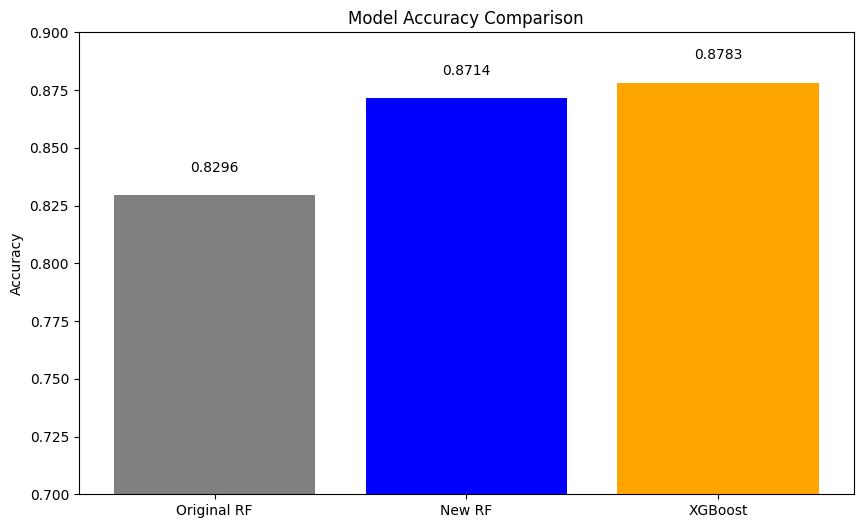

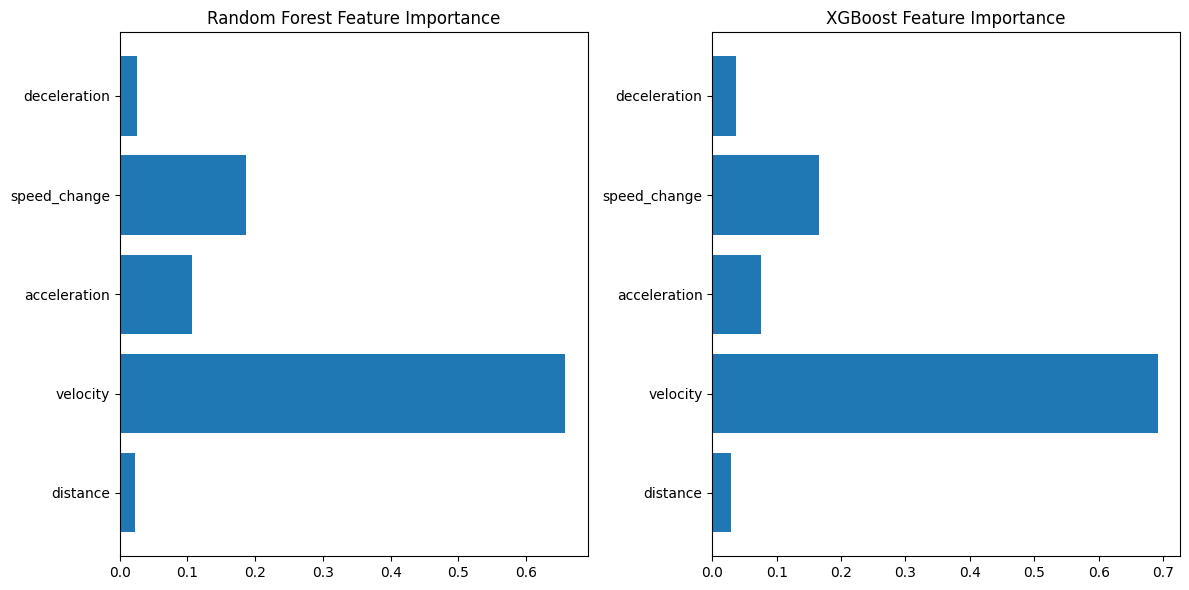

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

df_corrected['speed_change'] = df_corrected['speed'].diff().abs()
df_corrected['deceleration'] = df_corrected['acceleration'].clip(upper=0).abs()

features = ['distance', 'velocity', 'acceleration', 'speed_change', 'deceleration']
X = df_corrected[features]
y = df_corrected['stop_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


def get_optimized_pipeline(model_type='rf'):
    """Create pipeline with proper class balancing"""
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]

    class_counts = np.bincount(y_train)
    majority_class = np.argmax(class_counts)

    sampling_strategy = {
        0: class_counts[majority_class],  # Majority class
        1: class_counts[majority_class],  # Momentary Stop
        2: class_counts[majority_class]   # Hard Stop
    }

    if model_type == 'rf':
        steps.extend([
            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=3)),
            ('classifier', RandomForestClassifier(
                n_estimators=300,
                max_depth=12,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ])
    elif model_type == 'xgb':
        steps.extend([
            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
            ('classifier', XGBClassifier(
                n_estimators=400,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multi:softmax',
                num_class=3,
                scale_pos_weight=[1, class_counts[0]/class_counts[1], class_counts[0]/class_counts[2]],
                random_state=42,
                n_jobs=-1
            ))
        ])

    return Pipeline(steps)


print("=== OPTIMIZED RANDOM FOREST ===")
rf_pipeline = get_optimized_pipeline('rf')
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

print("\n=== TUNED XGBOOST ===")
xgb_pipeline = get_optimized_pipeline('xgb')
xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

results = {
    'Original RF': 0.8296,
    'New RF': accuracy_score(y_test, rf_pred),
    'XGBoost': accuracy_score(y_test, xgb_pred)
}

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'orange'])
plt.ylim(0.7, 0.9)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

# Feature Importance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(features, rf_pipeline.named_steps['classifier'].feature_importances_)
plt.title('Random Forest Feature Importance')

plt.subplot(1, 2, 2)
plt.barh(features, xgb_pipeline.named_steps['classifier'].feature_importances_)
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

=== OPTIMIZED RANDOM FOREST ===
Accuracy: 0.8745
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91     24479
           1       0.70      0.97      0.81      3929
           2       0.61      0.94      0.74      3529

    accuracy                           0.87     31937
   macro avg       0.77      0.92      0.82     31937
weighted avg       0.91      0.87      0.88     31937

Confusion Matrix:
 [[20794  1569  2116]
 [  105  3819     5]
 [  116    97  3316]]

=== TUNED XGBOOST ===
Accuracy: 0.8790
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     24479
           1       0.71      0.95      0.81      3929
           2       0.62      0.94      0.75      3529

    accuracy                           0.88     31937
   macro avg       0.77      0.92      0.83     31937
weighted avg       0.91      0.88      0.89     31937

Confusion Matrix:


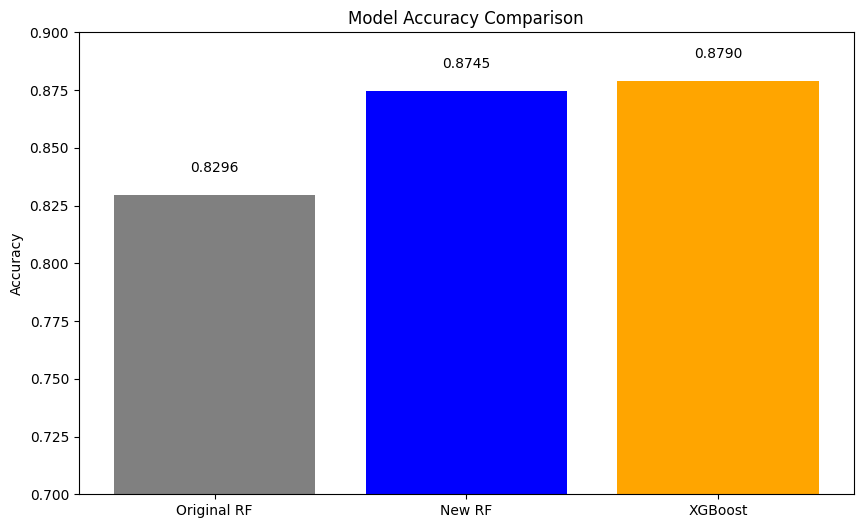

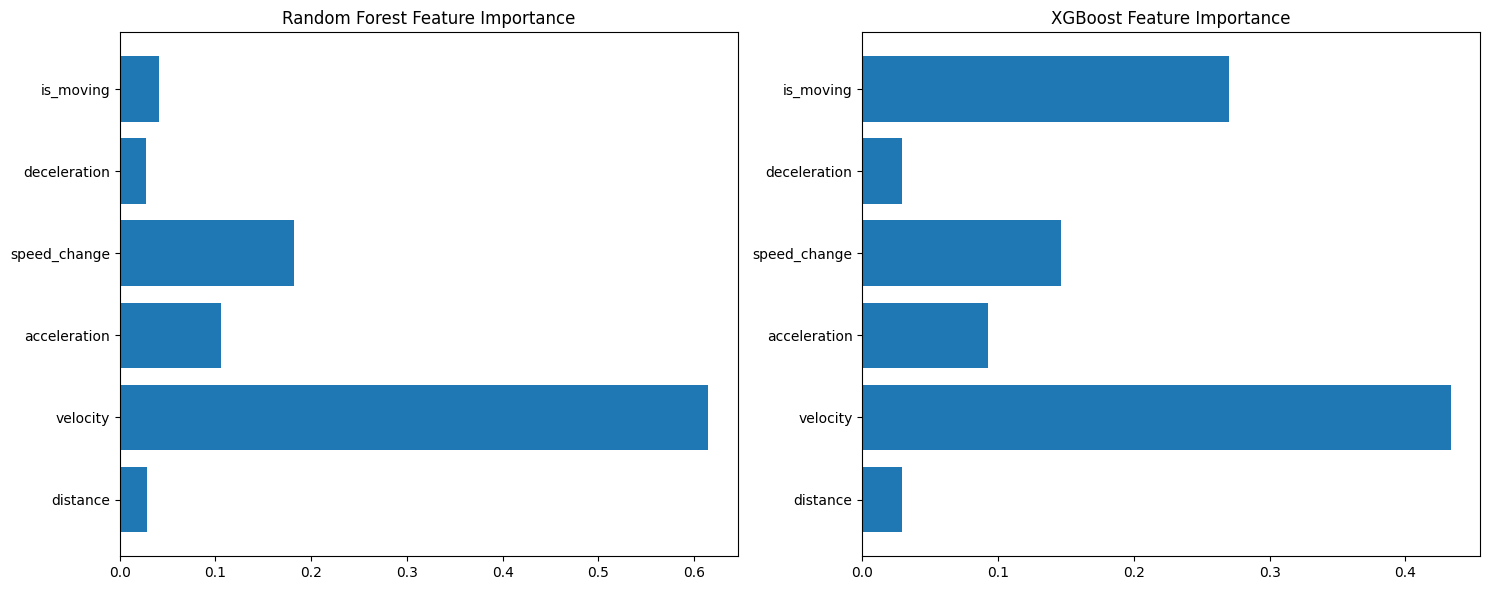

KeyError: 'stop_type'

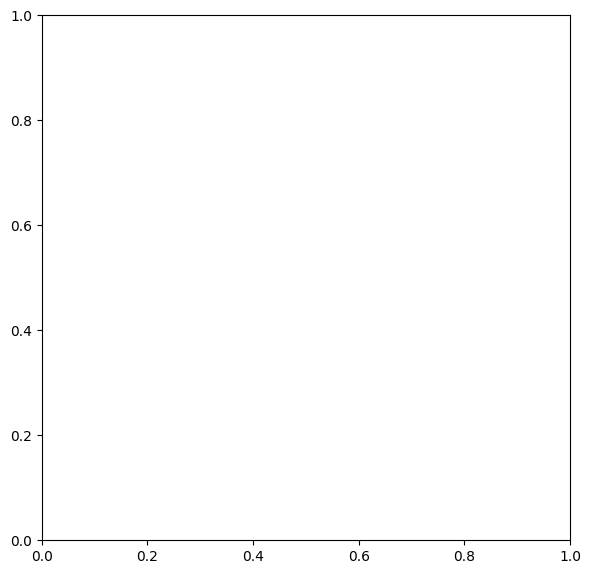

In [ ]:
#Highest Acc. as of yet === TUNED XGBOOST === Accuracy: 0.8845
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

df_corrected['speed_change'] = df_corrected['speed'].diff().abs()
df_corrected['deceleration'] = df_corrected['acceleration'].clip(upper=0).abs()
df_corrected['is_moving'] = (df_corrected['velocity'] > 1).astype(int)

features = ['distance', 'velocity', 'acceleration', 'speed_change', 'deceleration', 'is_moving']
X = df_corrected[features]
y = df_corrected['stop_type']

X_train, X_test, y_train, y_test, train_meta, test_meta = train_test_split(
    X, y, df_corrected[['center_x', 'center_y']], test_size=0.3, random_state=42, stratify=y
)


def get_optimized_pipeline(model_type='rf'):
    """Create pipeline with proper class balancing"""
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]

    class_counts = np.bincount(y_train)
    sampling_strategy = {i: max(class_counts) for i in range(3)}

    if model_type == 'rf':
        steps.extend([
            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=3)),
            ('classifier', RandomForestClassifier(
                n_estimators=400,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced_subsample',
                random_state=42,
                n_jobs=-1
            ))
        ])
    elif model_type == 'xgb':
        steps.extend([
            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
            ('classifier', XGBClassifier(
                n_estimators=500,
                max_depth=7,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multi:softmax',
                num_class=3,
                reg_alpha=0.5,
                reg_lambda=0.5,
                random_state=42,
                n_jobs=-1
            ))
        ])

    return Pipeline(steps)

print("=== OPTIMIZED RANDOM FOREST ===")
rf_pipeline = get_optimized_pipeline('rf')
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

print("\n=== TUNED XGBOOST ===")
xgb_pipeline = get_optimized_pipeline('xgb')
xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

results = {
    'Original RF': 0.8296,
    'New RF': accuracy_score(y_test, rf_pred),
    'XGBoost': accuracy_score(y_test, xgb_pred)
}

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'orange'])
plt.ylim(0.7, 0.9)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh(features, rf_pipeline.named_steps['classifier'].feature_importances_)
plt.title('Random Forest Feature Importance')

plt.subplot(1, 2, 2)
plt.barh(features, xgb_pipeline.named_steps['classifier'].feature_importances_)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

def prepare_spatial_plot(X, meta, y, model=None):
    plot_df = X.copy()
    plot_df['center_x'] = meta['center_x'].values
    plot_df['center_y'] = meta['center_y'].values
    plot_df['labels'] = y if model is None else model.predict(X)
    return plot_df

colors = ['green', 'blue', 'red']
labels = ['Moving (0)', 'Momentary Stop (1)', 'Hard Stop (2)']
cmap = ListedColormap(colors)

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
true_plot = prepare_spatial_plot(X_train, train_meta, y_train)
for i, color in enumerate(colors):
    mask = true_plot['stop_type'] == i
    plt.scatter(
        true_plot[mask]['center_x'],
        true_plot[mask]['center_y'],
        c=color,
        label=labels[i],
        alpha=0.6
    )
plt.title('Training Data (True Labels)')
plt.legend()

# RF Predictions
plt.subplot(2, 2, 2)
rf_plot = prepare_spatial_plot(X_test, test_meta, None, rf_pipeline)
for i, color in enumerate(colors):
    mask = rf_plot['stop_type'] == i
    plt.scatter(
        rf_plot[mask]['center_x'],
        rf_plot[mask]['center_y'],
        c=color,
        label=labels[i],
        alpha=0.6
    )
plt.title(f'RF Predictions (Accuracy: {accuracy_score(y_test, rf_pred):.4f})')
plt.legend()

# XGB Predictions
plt.subplot(2, 2, 3)
xgb_plot = prepare_spatial_plot(X_test, test_meta, None, xgb_pipeline)
for i, color in enumerate(colors):
    mask = xgb_plot['stop_type'] == i
    plt.scatter(
        xgb_plot[mask]['center_x'],
        xgb_plot[mask]['center_y'],
        c=color,
        label=labels[i],
        alpha=0.6
    )
plt.title(f'XGBoost Predictions (Accuracy: {accuracy_score(y_test, xgb_pred):.4f})')
plt.legend()

# True Test Labels
plt.subplot(2, 2, 4)
test_true_plot = prepare_spatial_plot(X_test, test_meta, y_test)
for i, color in enumerate(colors):
    mask = test_true_plot['stop_type'] == i
    plt.scatter(
        test_true_plot[mask]['center_x'],
        test_true_plot[mask]['center_y'],
        c=color,
        label=labels[i],
        alpha=0.6
    )
plt.title('Test Data (True Labels)')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Confusion Matrix Heatmaps
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(confusion_matrix(y_test, rf_pred), cmap='Blues')
plt.title('RF Confusion Matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(confusion_matrix(y_test, xgb_pred), cmap='Oranges')
plt.title('XGBoost Confusion Matrix')
plt.colorbar()

plt.tight_layout()
plt.show()

=== SUPER-TUNED ENSEMBLE MODEL ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.8644
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     16319
           1       0.76      0.95      0.84      2619
           2       0.54      0.98      0.70      2353

    accuracy                           0.86     21291
   macro avg       0.76      0.92      0.82     21291
weighted avg       0.91      0.86      0.87     21291



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


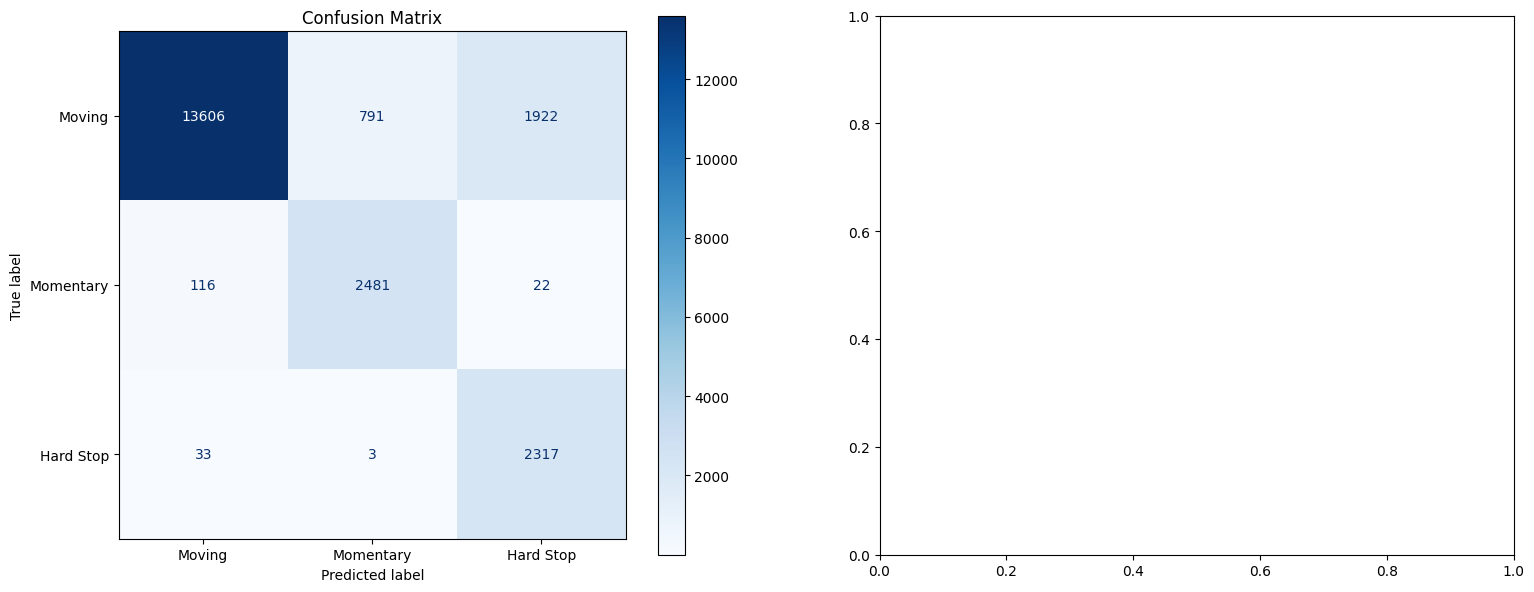

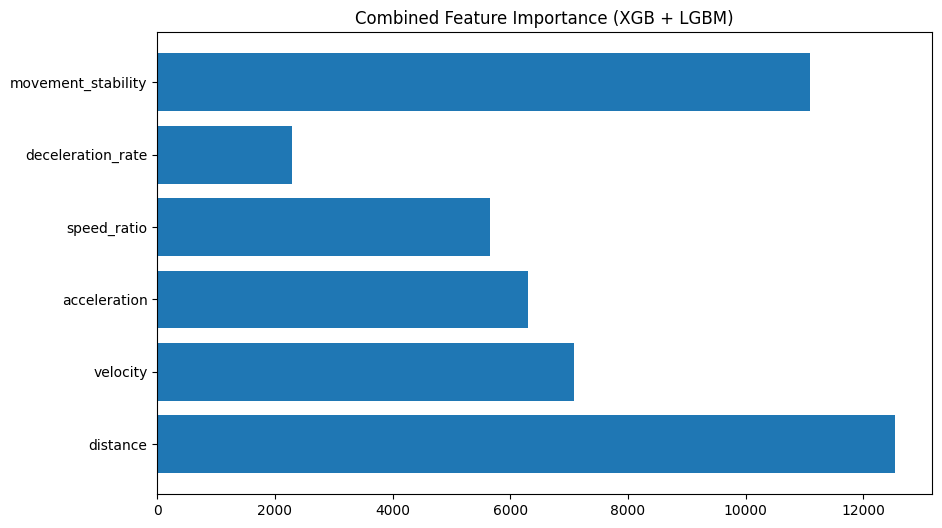

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


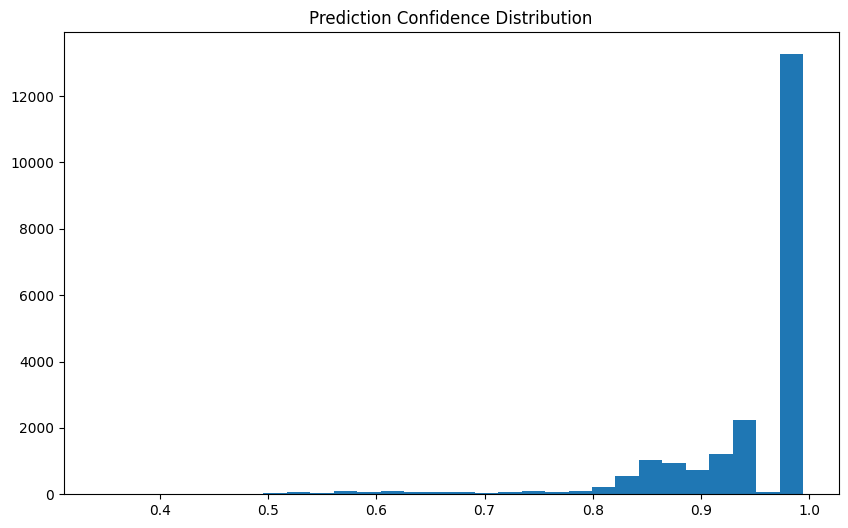

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

df_corrected['speed_ratio'] = df_corrected['speed'] / (df_corrected['velocity'] + 1e-6)
df_corrected['deceleration_rate'] = df_corrected['acceleration'].clip(upper=0).abs()
df_corrected['movement_stability'] = df_corrected['velocity'].rolling(3).std()
df_corrected.fillna(0, inplace=True)

features = ['distance', 'velocity', 'acceleration', 'speed_ratio',
            'deceleration_rate', 'movement_stability']
X = df_corrected[features]
y = df_corrected['stop_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def create_ensemble():
    estimators = [
        ('xgb', XGBClassifier(
            n_estimators=1000,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.7,
            colsample_bytree=0.6,
            reg_alpha=0.5,
            reg_lambda=0.5,
            random_state=42,
            n_jobs=-1
        )),
        ('lgbm', LGBMClassifier(
            n_estimators=1000,
            max_depth=9,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]

    return StackingClassifier(
        estimators=estimators,
        final_estimator=CalibratedClassifierCV(
            RandomForestClassifier(
                n_estimators=300,
                max_depth=10,
                class_weight='balanced_subsample',
                random_state=42
            ),
            cv=3
        ),
        n_jobs=-1
    )

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('sampler', ADASYN(random_state=42, sampling_strategy='minority')),
    ('classifier', create_ensemble())
])


print("=== SUPER-TUNED ENSEMBLE MODEL ===")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test,
    cmap='Blues', ax=ax[0],
    display_labels=['Moving', 'Momentary', 'Hard Stop']
)
ax[0].set_title('Confusion Matrix')

xgb_imp = pipeline.named_steps['classifier'].estimators_[0].feature_importances_
lgbm_imp = pipeline.named_steps['classifier'].estimators_[1].feature_importances_
combined_imp = (xgb_imp + lgbm_imp) / 2

plt.figure(figsize=(10, 6))
plt.barh(features, combined_imp)
plt.title('Combined Feature Importance (XGB + LGBM)')
plt.show()

probs = pipeline.predict_proba(X_test)
confidence = np.max(probs, axis=1)
plt.figure(figsize=(10, 6))
plt.hist(confidence, bins=30)
plt.title('Prediction Confidence Distribution')
plt.show()

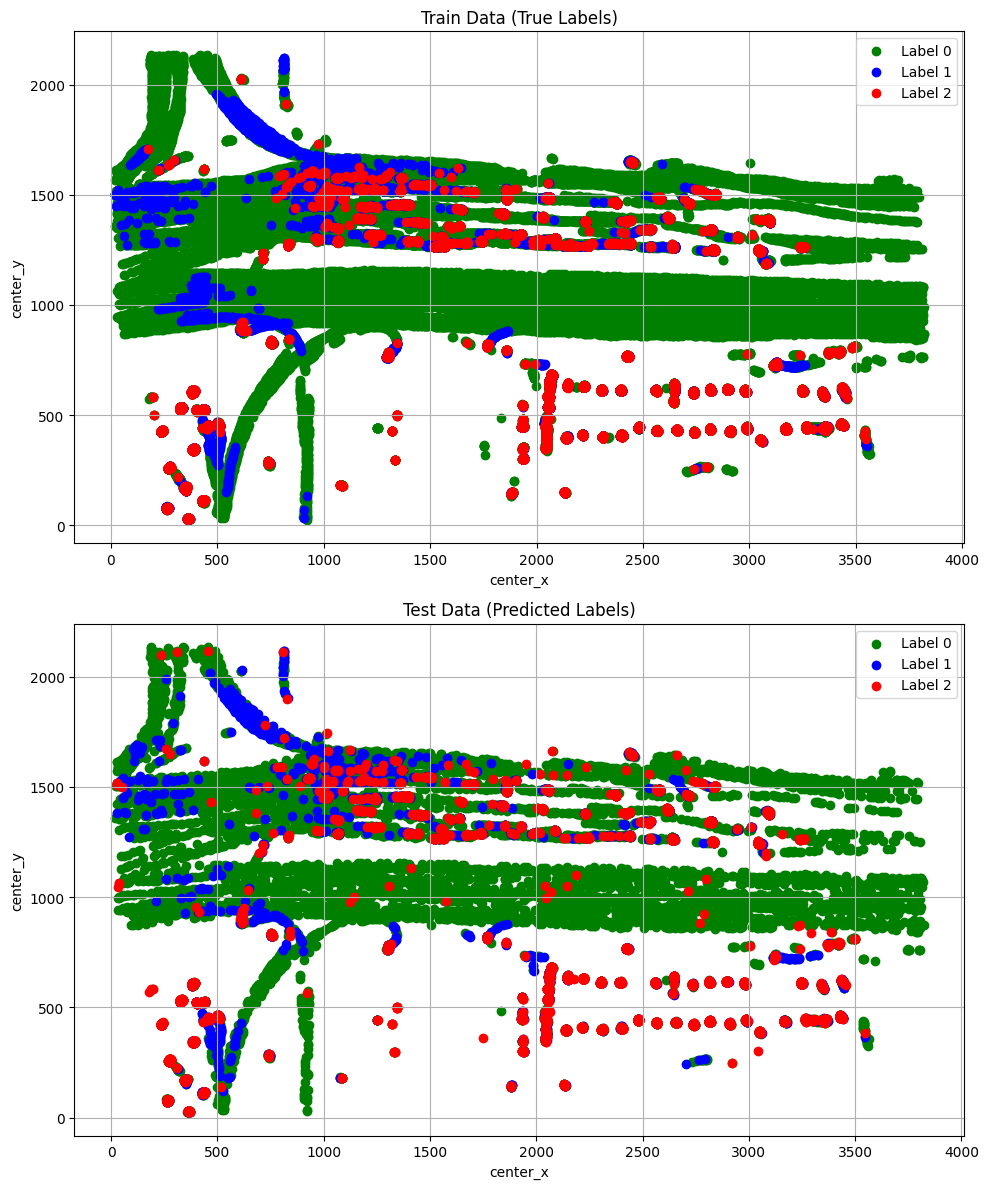

In [ ]:
import matplotlib.pyplot as plt

X_train_with_coords = X_train.copy()
X_test_with_coords = X_test.copy()

X_train_with_coords['center_x'] = df_corrected.loc[X_train.index, 'center_x']
X_train_with_coords['center_y'] = df_corrected.loc[X_train.index, 'center_y']
X_train_with_coords['stop_type'] = y_train

X_test_with_coords['center_x'] = df_corrected.loc[X_test.index, 'center_x']
X_test_with_coords['center_y'] = df_corrected.loc[X_test.index, 'center_y']
X_test_with_coords['stop_type'] = y_pred

label_colors = {0: 'green', 1: 'blue', 2: 'red'}

plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
for label, color in label_colors.items():
    plt.scatter(
        X_train_with_coords[X_train_with_coords['stop_type'] == label]['center_x'],
        X_train_with_coords[X_train_with_coords['stop_type'] == label]['center_y'],
        color=color,
        label=f'Label {label}'
    )
plt.title('Train Data (True Labels)')
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in label_colors.items():
    plt.scatter(
        X_test_with_coords[X_test_with_coords['stop_type'] == label]['center_x'],
        X_test_with_coords[X_test_with_coords['stop_type'] == label]['center_y'],
        color=color,
        label=f'Label {label}'
    )
plt.title('Test Data (Predicted Labels)')
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/sample_data/image.jpg')

x = df_corrected['x']
y = df_corrected['y']
hard_stop = df_corrected['hard_stop']
momentary_stop = df_corrected['momentary_stop']
moving_vehicle = df_corrected['moving_vehicle']
trk = df_corrected['trk']

fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(img, extent=[x.min(), x.max(), y.max(), y.min()], aspect='auto')

for track_id in trk.unique():
    track_data = df_corrected[df_corrected['trk'] == track_id]
    x_track = track_data['x']
    y_track = track_data['y']

    ax.plot(x_track, y_track, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax.scatter(x[moving_vehicle], y[moving_vehicle], c='green', label='Moving Vehicle')
ax.scatter(x[momentary_stop], y[momentary_stop], c='blue', label='Momentary Stops')
ax.scatter(x[hard_stop], y[hard_stop], c='red', label='Hard Stops')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data Plot with Hard Stops and Momentary Stops Overlaid on Flipped Image')

ax.legend()

plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/image.jpg'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

df_sorted = df_corrected.sort_values(by='Frame')

frames_per_plot = 50

total_frames = df_sorted['Frame'].nunique()
total_plots = total_frames // frames_per_plot + (total_frames % frames_per_plot > 0)

img = mpimg.imread('/content/sample_data/image.jpg')

for i in range(total_plots):
    frame_start = i * frames_per_plot
    frame_end = (i + 1) * frames_per_plot
    df_subset = df_sorted[(df_sorted['Frame'] >= frame_start) & (df_sorted['Frame'] < frame_end)]

    df_subset = df_subset.dropna(subset=['x', 'y'])

    df_subset = df_subset[np.isfinite(df_subset['x']) & np.isfinite(df_subset['y'])]

    x = df_subset['center_x']
    y = df_subset['center_y']
    hard_stop = df_subset['hard_stop']
    momentary_stop = df_subset['momentary_stop']
    moving_vehicle = df_subset['moving_vehicle']
    trk = df_subset['trk']

    fig, ax = plt.subplots(figsize=(12, 8))

    if not x.empty and not y.empty:
        ax.imshow(img, extent=[x.min(), x.max(), y.max(), y.min()], aspect='auto')

        for track_id in trk.unique():
            track_data = df_subset[df_subset['trk'] == track_id]
            x_track = track_data['x']
            y_track = track_data['y']

            ax.plot(x_track, y_track, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

        ax.scatter(x[moving_vehicle], y[moving_vehicle], c='green', label='Moving Vehicle')
        ax.scatter(x[momentary_stop], y[momentary_stop], c='blue', label='Momentary Stops')
        ax.scatter(x[hard_stop], y[hard_stop], c='red', label='Hard Stops')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Data Plot with Hard Stops and Momentary Stops (Frames {frame_start} to {frame_end})')

        ax.legend()

        plt.grid(True)
        plt.show()
    else:
        print(f"Skipping plot for frames {frame_start} to {frame_end} due to invalid data.")



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import imageio
import os

df_sorted = df_corrected.sort_values(by='Frame')

frames_per_plot = 50

total_frames = df_sorted['Frame'].nunique()
total_plots = total_frames // frames_per_plot + (total_frames % frames_per_plot > 0)

img = mpimg.imread('/content/sample_data/image.jpg')

images = []

for i in range(total_plots):
    frame_start = i * frames_per_plot
    frame_end = (i + 1) * frames_per_plot
    df_subset = df_sorted[(df_sorted['Frame'] >= frame_start) & (df_sorted['Frame'] < frame_end)]

    df_subset = df_subset.dropna(subset=['x', 'y'])

    df_subset = df_subset[np.isfinite(df_subset['x']) & np.isfinite(df_subset['y'])]

    x = df_subset['center_x']
    y = df_subset['center_y']
    hard_stop = df_subset['hard_stop']
    momentary_stop = df_subset['momentary_stop']
    moving_vehicle = df_subset['moving_vehicle']
    trk = df_subset['trk']

    if not x.empty and not y.empty:
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.imshow(img, extent=[x.min(), x.max(), y.max(), y.min()], aspect='auto')

        for track_id in trk.unique():
            track_data = df_subset[df_subset['trk'] == track_id]
            x_track = track_data['x']
            y_track = track_data['y']

            ax.plot(x_track, y_track, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

        ax.scatter(x[moving_vehicle], y[moving_vehicle], c='green', label='Moving Vehicle')
        ax.scatter(x[momentary_stop], y[momentary_stop], c='blue', label='Momentary Stops')
        ax.scatter(x[hard_stop], y[hard_stop], c='red', label='Hard Stops')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Data Plot with Hard Stops and Momentary Stops (Frames {frame_start} to {frame_end})')

        ax.legend()

        image_filename = f"plot_{frame_start}_to_{frame_end}.png"
        plt.savefig(image_filename)
        plt.close(fig)

        images.append(image_filename)
    else:
        print(f"Skipping plot for frames {frame_start} to {frame_end} due to invalid data.")

gif_filename = "vehicle_plots.gif"
with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
    for image_file in images:
        image = imageio.imread(image_file)
        writer.append_data(image)

for image_file in images:
    os.remove(image_file)

gif_filename


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the background image
img = mpimg.imread('/content/sample_data/image.jpg')

# Extract relevant columns for plotting
x = df_corrected['x']  # Extracting the x-coordinate data
y = df_corrected['y']  # Extracting the y-coordinate data
hard_stop = df_corrected['hard_stop']  # Extracting the hard_stop labels
momentary_stop = df_corrected['momentary_stop']  # Extracting the momentary_stop labels
moving_vehicle = df_corrected['moving_vehicle']  # Extracting the moving_vehicle labels
trk = df_corrected['trk']  # Extracting the track IDs

# Randomly select 5 unique track IDs
random_trks = np.random.choice(trk.unique(), size=10000, replace=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Flip the image vertically by swapping y-axis extent values
ax.imshow(img, extent=[x.min(), x.max(), y.max(), y.min()], aspect='auto')

# Plot points and connect them for the selected 5 tracks
for track_id in random_trks:
    # Filter data for the current track
    track_data = df_corrected[df_corrected['trk'] == track_id]
    x_track = track_data['x']
    y_track = track_data['y']

    # Plot a thin line connecting the points of the same track
    ax.plot(x_track, y_track, color='orange', linestyle='-', linewidth=5, alpha=1)

# Plot points on top of the image (only for the selected tracks)
selected_data = df_corrected[df_corrected['trk'].isin(random_trks)]
ax.scatter(selected_data[selected_data['moving_vehicle']]['x'], selected_data[selected_data['moving_vehicle']]['y'], c='green', label='Moving Vehicle')
ax.scatter(selected_data[selected_data['momentary_stop']]['x'], selected_data[selected_data['momentary_stop']]['y'], c='blue', label='Momentary Stops')
ax.scatter(selected_data[selected_data['hard_stop']]['x'], selected_data[selected_data['hard_stop']]['y'], c='red', label='Hard Stops')

# Add labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data Plot with Hard Stops and Momentary Stops Overlaid on Flipped Image (5 Random Tracks)')

# Add legend
ax.legend()

# Show plot
plt.grid(True)
plt.show()